Deep Learningで使われる最適化アルゴリズムには色々あるんだけど、それらの振る舞いがどんな風に異なるのか、というのが気になったのでTensorFlowで試してみた。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import tensorflow as tf

## 便利関数の準備

回転行列を作る関数

In [2]:
def rotation_matrix(th):
    ret = np.zeros((2,2))
    ret[0,0], ret[0,1] = np.cos(th), -np.sin(th)
    ret[1,0], ret[1,1] = np.sin(th), np.cos(th)
    return ret

関数の等高線を描くための関数

In [14]:
def plot_contour(xlim, ylim, f, ax):
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    x, y = np.meshgrid(x, y)
    z = f(x, y)
    if type(z) == tf.Tensor:
        with tf.Session() as sess:
            z = sess.run(z)
    cntr = ax.contourf(x, y, z,levels=100)
    return x,y,z,cntr

$\alpha(x-a)^2 + \beta(x-b)^2$を$\theta$回転させた関数

In [15]:
def quad(x, y, a, b, alpha, beta, theta):
    x = x - a
    y = y - b
    mat = rotation_matrix(-theta)
    X = np.array((x, y))
    x, y = np.tensordot(mat, X, (1, 0))
    return alpha * x ** 2 + beta * y ** 2

最適化アルゴリズムを与えられて、実際に走らせる関数

In [16]:
def run_optimize(optimizer, param, num_step=100): # 最適化を走らせる関数
    param_hist = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        param_hist.append(sess.run(param))
        for _ in range(num_step):
            sess.run(optimizer)
            var = sess.run(param)
            param_hist.append(var)
    return np.array(param_hist)

## 最適化対象の関数の定義

ここから、最適化対象の関数を作る。単純に細長い楕円としてみる。

In [24]:
def f(x, y):
    return quad(x, y, 0, 0, 0.01, 1, 0)

In [42]:
def f(x, y):
    return 0.0001 * x**2 - 0.0001 * y**2

等高線を描くと、こんな感じ。

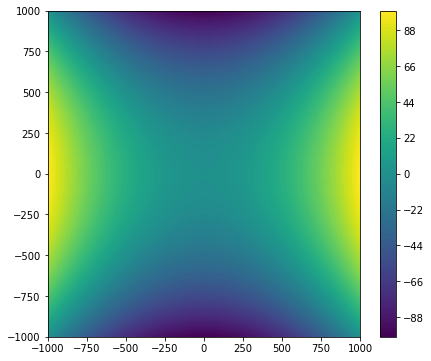

In [43]:
fig, ax = plt.subplots(figsize=(7,6))
_,_,_,ctr = plot_contour((-1000, 1000), (-1000, 1000), f, ax)
fig.colorbar(ctr)
plt.show()

左右に長い、超悪条件の関数

## 最適化を実施

以下、実際に最適化するコードが続く。4種類のアルゴリズムを試す。

In [47]:
X = tf.Variable(1000, dtype=tf.float32)
Y = tf.Variable(1, dtype=tf.float32)
COST = f(X, Y)
opt_step = 400 # 最適化のステップ数

X,Yの初期値に0,10を指定しているので、xy-平面の(0,10)から出発点となる。

In [52]:
learn_rate = 1

gd_step = tf.train.GradientDescentOptimizer(learn_rate*10).minimize(COST)
gd_hist = run_optimize(gd_step, (X, Y), opt_step)

adam_step = tf.train.AdamOptimizer(
    learning_rate=learn_rate,
    beta1=0.9,
    beta2=0.999,    
    epsilon=1e-08).minimize(COST)
adam_hist = run_optimize(adam_step, (X, Y), opt_step)

rms_step = tf.train.RMSPropOptimizer(
    learning_rate=learn_rate,
    decay=0.9,
    momentum=0.0,
    epsilon=1e-8
).minimize(COST)
rms_hist = run_optimize(rms_step, (X, Y), opt_step)

adagrad_step = tf.train.AdagradOptimizer(
    learning_rate=learn_rate*10,
    initial_accumulator_value=0.1
).minimize(COST)
adagrad_hist = run_optimize(adagrad_step, (X, Y), opt_step)

最適化結果をプロットしてみる。

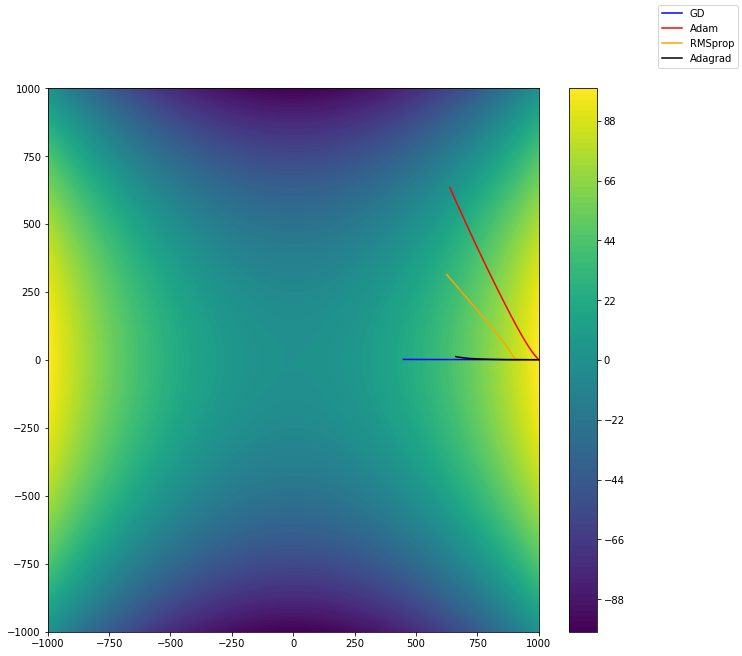

In [53]:
fig, ax = fig, ax = plt.subplots(figsize=(11,10))
x,y,z,ctr = plot_contour((-1000,1000), (-1000,1000), f, ax)
ax.plot(gd_hist[:,0], gd_hist[:,1], color='blue', label='GD')
ax.plot(adam_hist[:,0], adam_hist[:,1], color='red', label='Adam')
ax.plot(rms_hist[:,0], rms_hist[:,1], color='orange', label='RMSprop')
ax.plot(adagrad_hist[:,0], adagrad_hist[:,1], color='black', label='Adagrad')
fig.colorbar(ctr)
fig.legend()

Adam, RMSPropは最適値にとどいているが、Adagrad, GradientDescentは400ステップでは全然、最適値に届いていない。当たり前だが、学習率などのパラメータによって振る舞いは変わるはず。本当はいろいろ試したいが、手で動かすのは大変なのでアプリでも作りたいところ。

最後に、アニメーションを作る。

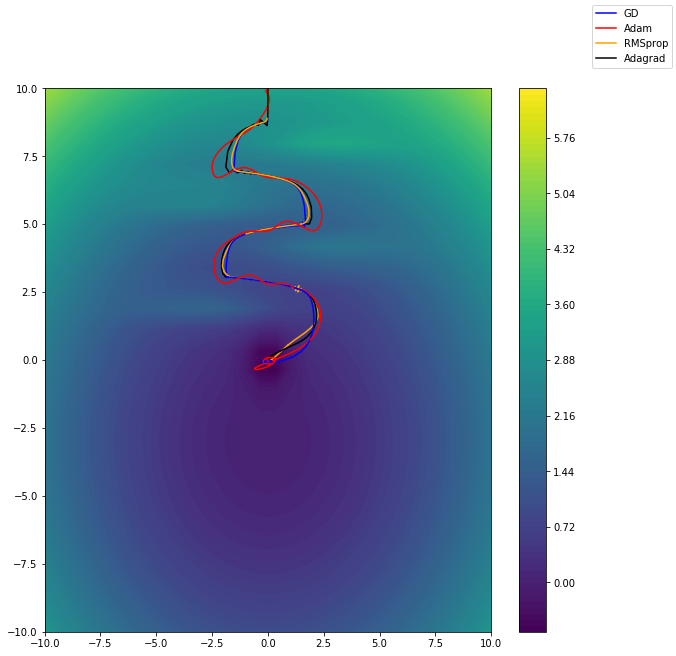

In [63]:
step = 20
index1 = 0
index2 = index1 + step
fig, ax = fig, ax = plt.subplots(figsize=(10,10))
x,y,z,ctr = plot_contour((-11,11), (-11,11), f, ax)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
fig.colorbar(ctr)
def plot_frame(data):    
    global index1, index2
    ## print(index1, index2)
    ax.plot(gd_hist[index1:index2,0], gd_hist[index1:index2,1], color='blue', label='GD')
    ax.plot(adam_hist[index1:index2,0], adam_hist[index1:index2,1], color='red', label='Adam')
    ax.plot(rms_hist[index1:index2,0], rms_hist[index1:index2,1], color='orange', label='RMSprop')
    ax.plot(adagrad_hist[index1:index2,0], adagrad_hist[index1:index2,1], color='black', label='Adagrad')
    if index1 == 0: fig.legend()
    index1, index2 = index2-1, index2 + step
    
ani = anm.FuncAnimation(fig, plot_frame, interval=70, frames=opt_step//step)
ani.save("output.gif", writer="pillow")